In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Optional: reset peak memory stats
torch.cuda.reset_peak_memory_stats()

Device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Total VRAM: 4.08 GB


In [2]:
import os
import copy
import time
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

# ─── Configuration ──────────────────────────────────────────────────────────────
data_dir    = 'brain2_gaussian'
batch_size  = 8               # reduced for 4 GB GPU
accum_steps = 4               # → effective batch ≈ 32
num_epochs  = 20              # adjust 15–30
learning_rate = 1e-3
img_size    = 224

num_classes = 4
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

save_dir = "ensemble_brain_tumor_models"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()   # for mixed precision

/tmp/ipykernel_26916/3571102443.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # for mixed precision


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((img_size + 24, img_size + 24)),
    transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), train_transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'Testing'),  val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset):,} images | Test: {len(test_dataset):,} images")
print("Classes:", train_dataset.classes)

Train: 5,712 images | Test: 1,311 images
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
def create_model(model_name):
    if model_name == "efficientnet_b4":
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "convnext_base":
        model = models.convnext_base(weights='IMAGENET1K_V1')
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model.to(device)


model_names = ["mobilenet_v3_large", "efficientnet_b4", "convnext_base"]   # order: lightest → heaviest

In [5]:
def train_single_model(model_name, epochs=num_epochs):
    model = create_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}  |  {model_name}")

        # ─── Train ───────────────────────────────────────
        model.train()
        running_loss = 0.0
        running_correct = 0
        optimizer.zero_grad()

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Train")):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss = loss / accum_steps
            scaler.scale(loss).backward()

            running_loss += loss.item() * accum_steps * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += torch.sum(preds == labels.data)

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        # leftover gradients
        if (i + 1) % accum_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc  = running_correct.double() / len(train_loader.dataset)

        # ─── Validate ────────────────────────────────────
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Valid", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(test_loader.dataset)
        epoch_val_acc  = val_correct.double() / len(test_loader.dataset)

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f}   | Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_wts = copy.deepcopy(model.state_dict())
            torch.save(best_wts, os.path.join(save_dir, f"best_{model_name}.pth"))
            print(f"→ Saved best ({epoch_val_acc:.4f})")

        scheduler.step()

    model.load_state_dict(best_wts)
    return model, history

In [6]:
histories = {}

for name in model_names:
    print(f"\n{'═'*70}\nStarting training: {name.upper()}\n{'═'*70}")
    
    trained_model, hist = train_single_model(name)
    histories[name] = hist
    
    # Save & cleanup
    torch.save(trained_model.state_dict(), os.path.join(save_dir, f"final_{name}.pth"))
    
    del trained_model
    torch.cuda.empty_cache()
    print(f"→ Memory cleared after {name} | VRAM used: {torch.cuda.memory_allocated()/1e9:.2f} GB\n")


══════════════════════════════════════════════════════════════════════
Starting training: MOBILENET_V3_LARGE
══════════════════════════════════════════════════════════════════════

Epoch 1/20  |  mobilenet_v3_large


Train:   0%|          | 0/714 [00:00<?, ?it/s]/tmp/ipykernel_26916/1787014087.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Valid:   0%|          | 0/164 [00:00<?, ?it/s]/tmp/ipykernel_26916/1787014087.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.3916 | Acc: 0.8620
Val   Loss: 0.1517   | Acc: 0.9512
→ Saved best (0.9512)

Epoch 2/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.45it/s]


Train Loss: 0.2259 | Acc: 0.9203
Val   Loss: 0.1672   | Acc: 0.9390

Epoch 3/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.56it/s]


Train Loss: 0.1681 | Acc: 0.9414
Val   Loss: 0.5191   | Acc: 0.8581

Epoch 4/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 35.96it/s]


Train Loss: 0.1301 | Acc: 0.9550
Val   Loss: 0.1437   | Acc: 0.9565
→ Saved best (0.9565)

Epoch 5/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 35.71it/s]


Train Loss: 0.1047 | Acc: 0.9645
Val   Loss: 0.1215   | Acc: 0.9603
→ Saved best (0.9603)

Epoch 6/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 34.76it/s]


Train Loss: 0.0947 | Acc: 0.9671
Val   Loss: 0.0730   | Acc: 0.9771
→ Saved best (0.9771)

Epoch 7/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.13it/s]


Train Loss: 0.0870 | Acc: 0.9716
Val   Loss: 0.0467   | Acc: 0.9847
→ Saved best (0.9847)

Epoch 8/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.05it/s]


Train Loss: 0.0780 | Acc: 0.9732
Val   Loss: 0.1513   | Acc: 0.9481

Epoch 9/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.64it/s]


Train Loss: 0.0546 | Acc: 0.9834
Val   Loss: 0.0783   | Acc: 0.9764

Epoch 10/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.56it/s]


Train Loss: 0.0348 | Acc: 0.9893
Val   Loss: 0.0462   | Acc: 0.9855
→ Saved best (0.9855)

Epoch 11/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.44it/s]


Train Loss: 0.0344 | Acc: 0.9886
Val   Loss: 0.0401   | Acc: 0.9886
→ Saved best (0.9886)

Epoch 12/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.15it/s]


Train Loss: 0.0366 | Acc: 0.9874
Val   Loss: 0.0243   | Acc: 0.9916
→ Saved best (0.9916)

Epoch 13/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.26it/s]


Train Loss: 0.0150 | Acc: 0.9949
Val   Loss: 0.0306   | Acc: 0.9916

Epoch 14/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.30it/s]


Train Loss: 0.0217 | Acc: 0.9939
Val   Loss: 0.0280   | Acc: 0.9939
→ Saved best (0.9939)

Epoch 15/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 35.74it/s]


Train Loss: 0.0132 | Acc: 0.9953
Val   Loss: 0.0191   | Acc: 0.9954
→ Saved best (0.9954)

Epoch 16/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.57it/s]


Train Loss: 0.0105 | Acc: 0.9965
Val   Loss: 0.0160   | Acc: 0.9962
→ Saved best (0.9962)

Epoch 17/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.53it/s]


Train Loss: 0.0103 | Acc: 0.9970
Val   Loss: 0.0200   | Acc: 0.9954

Epoch 18/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:20<00:00, 35.66it/s]


Train Loss: 0.0042 | Acc: 0.9988
Val   Loss: 0.0192   | Acc: 0.9954

Epoch 19/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 35.95it/s]


Train Loss: 0.0066 | Acc: 0.9979
Val   Loss: 0.0195   | Acc: 0.9969
→ Saved best (0.9969)

Epoch 20/20  |  mobilenet_v3_large


Train: 100%|██████████| 714/714 [00:19<00:00, 36.19it/s]


Train Loss: 0.0059 | Acc: 0.9975
Val   Loss: 0.0195   | Acc: 0.9969
→ Memory cleared after mobilenet_v3_large | VRAM used: 0.04 GB


══════════════════════════════════════════════════════════════════════
Starting training: EFFICIENTNET_B4
══════════════════════════════════════════════════════════════════════

Epoch 1/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:29<00:00,  8.00it/s]


Train Loss: 0.3949 | Acc: 0.8536
Val   Loss: nan   | Acc: 0.9504
→ Saved best (0.9504)

Epoch 2/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:17<00:00,  9.24it/s]


Train Loss: 0.1585 | Acc: 0.9482
Val   Loss: nan   | Acc: 0.9710
→ Saved best (0.9710)

Epoch 3/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.30it/s]


Train Loss: 0.1065 | Acc: 0.9613
Val   Loss: nan   | Acc: 0.9817
→ Saved best (0.9817)

Epoch 4/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.32it/s]


Train Loss: 0.0798 | Acc: 0.9746
Val   Loss: nan   | Acc: 0.9855
→ Saved best (0.9855)

Epoch 5/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.35it/s]


Train Loss: 0.0635 | Acc: 0.9779
Val   Loss: nan   | Acc: 0.9870
→ Saved best (0.9870)

Epoch 6/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.32it/s]


Train Loss: 0.0504 | Acc: 0.9832
Val   Loss: nan   | Acc: 0.9847

Epoch 7/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.33it/s]


Train Loss: 0.0448 | Acc: 0.9842
Val   Loss: nan   | Acc: 0.9886
→ Saved best (0.9886)

Epoch 8/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.35it/s]


Train Loss: 0.0264 | Acc: 0.9923
Val   Loss: nan   | Acc: 0.9847

Epoch 9/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.36it/s]


Train Loss: 0.0211 | Acc: 0.9925
Val   Loss: nan   | Acc: 0.9916
→ Saved best (0.9916)

Epoch 10/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:16<00:00,  9.34it/s]


Train Loss: 0.0286 | Acc: 0.9907
Val   Loss: 0.0427   | Acc: 0.9901

Epoch 11/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [01:00<00:00, 11.78it/s]


Train Loss: 0.0226 | Acc: 0.9921
Val   Loss: 0.0892   | Acc: 0.9916

Epoch 12/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.98it/s]


Train Loss: 0.0206 | Acc: 0.9937
Val   Loss: 0.0538   | Acc: 0.9939
→ Saved best (0.9939)

Epoch 13/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:54<00:00, 12.99it/s]


Train Loss: 0.0122 | Acc: 0.9953
Val   Loss: 0.0384   | Acc: 0.9954
→ Saved best (0.9954)

Epoch 14/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.97it/s]


Train Loss: 0.0092 | Acc: 0.9972
Val   Loss: 0.0116   | Acc: 0.9962
→ Saved best (0.9962)

Epoch 15/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.96it/s]


Train Loss: 0.0096 | Acc: 0.9974
Val   Loss: 0.0240   | Acc: 0.9962

Epoch 16/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.91it/s]


Train Loss: 0.0070 | Acc: 0.9975
Val   Loss: 0.0319   | Acc: 0.9954

Epoch 17/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.89it/s]


Train Loss: 0.0060 | Acc: 0.9982
Val   Loss: 0.0171   | Acc: 0.9969
→ Saved best (0.9969)

Epoch 18/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.89it/s]


Train Loss: 0.0042 | Acc: 0.9986
Val   Loss: 0.0190   | Acc: 0.9969

Epoch 19/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.93it/s]


Train Loss: 0.0071 | Acc: 0.9972
Val   Loss: 0.0158   | Acc: 0.9969

Epoch 20/20  |  efficientnet_b4


Train: 100%|██████████| 714/714 [00:55<00:00, 12.93it/s]


Train Loss: 0.0047 | Acc: 0.9989
Val   Loss: 0.0169   | Acc: 0.9969
→ Memory cleared after efficientnet_b4 | VRAM used: 0.09 GB


══════════════════════════════════════════════════════════════════════
Starting training: CONVNEXT_BASE
══════════════════════════════════════════════════════════════════════

Epoch 1/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:56<00:00,  6.13it/s]


Train Loss: 1.0527 | Acc: 0.5406
Val   Loss: 0.7500   | Acc: 0.7407
→ Saved best (0.7407)

Epoch 2/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.53it/s]


Train Loss: 0.5012 | Acc: 0.8160
Val   Loss: 0.3967   | Acc: 0.8688
→ Saved best (0.8688)

Epoch 3/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.54it/s]


Train Loss: 0.3366 | Acc: 0.8820
Val   Loss: 0.3524   | Acc: 0.8863
→ Saved best (0.8863)

Epoch 4/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.55it/s]


Train Loss: 0.2656 | Acc: 0.9056
Val   Loss: 0.2401   | Acc: 0.9321
→ Saved best (0.9321)

Epoch 5/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.54it/s]


Train Loss: 0.2246 | Acc: 0.9212
Val   Loss: 0.2819   | Acc: 0.9123

Epoch 6/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.55it/s]


Train Loss: 0.1848 | Acc: 0.9391
Val   Loss: 0.1460   | Acc: 0.9489
→ Saved best (0.9489)

Epoch 7/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.53it/s]


Train Loss: 0.1537 | Acc: 0.9489
Val   Loss: 0.1719   | Acc: 0.9413

Epoch 8/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:49<00:00,  6.55it/s]


Train Loss: 0.1508 | Acc: 0.9477
Val   Loss: 0.1119   | Acc: 0.9672
→ Saved best (0.9672)

Epoch 9/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.55it/s]


Train Loss: 0.1105 | Acc: 0.9625
Val   Loss: 0.1250   | Acc: 0.9596

Epoch 10/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0945 | Acc: 0.9674
Val   Loss: 0.0811   | Acc: 0.9725
→ Saved best (0.9725)

Epoch 11/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0730 | Acc: 0.9750
Val   Loss: 0.0689   | Acc: 0.9756
→ Saved best (0.9756)

Epoch 12/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.55it/s]


Train Loss: 0.0611 | Acc: 0.9795
Val   Loss: 0.0729   | Acc: 0.9779
→ Saved best (0.9779)

Epoch 13/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0568 | Acc: 0.9814
Val   Loss: 0.0348   | Acc: 0.9863
→ Saved best (0.9863)

Epoch 14/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0361 | Acc: 0.9876
Val   Loss: 0.0692   | Acc: 0.9809

Epoch 15/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0348 | Acc: 0.9890
Val   Loss: 0.0332   | Acc: 0.9878
→ Saved best (0.9878)

Epoch 16/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.57it/s]


Train Loss: 0.0260 | Acc: 0.9909
Val   Loss: 0.0291   | Acc: 0.9893
→ Saved best (0.9893)

Epoch 17/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.57it/s]


Train Loss: 0.0200 | Acc: 0.9932
Val   Loss: 0.0358   | Acc: 0.9878

Epoch 18/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.57it/s]


Train Loss: 0.0172 | Acc: 0.9951
Val   Loss: 0.0234   | Acc: 0.9924
→ Saved best (0.9924)

Epoch 19/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0164 | Acc: 0.9956
Val   Loss: 0.0172   | Acc: 0.9954
→ Saved best (0.9954)

Epoch 20/20  |  convnext_base


Train: 100%|██████████| 714/714 [01:48<00:00,  6.56it/s]


Train Loss: 0.0120 | Acc: 0.9954
Val   Loss: 0.0180   | Acc: 0.9947
→ Memory cleared after convnext_base | VRAM used: 0.37 GB



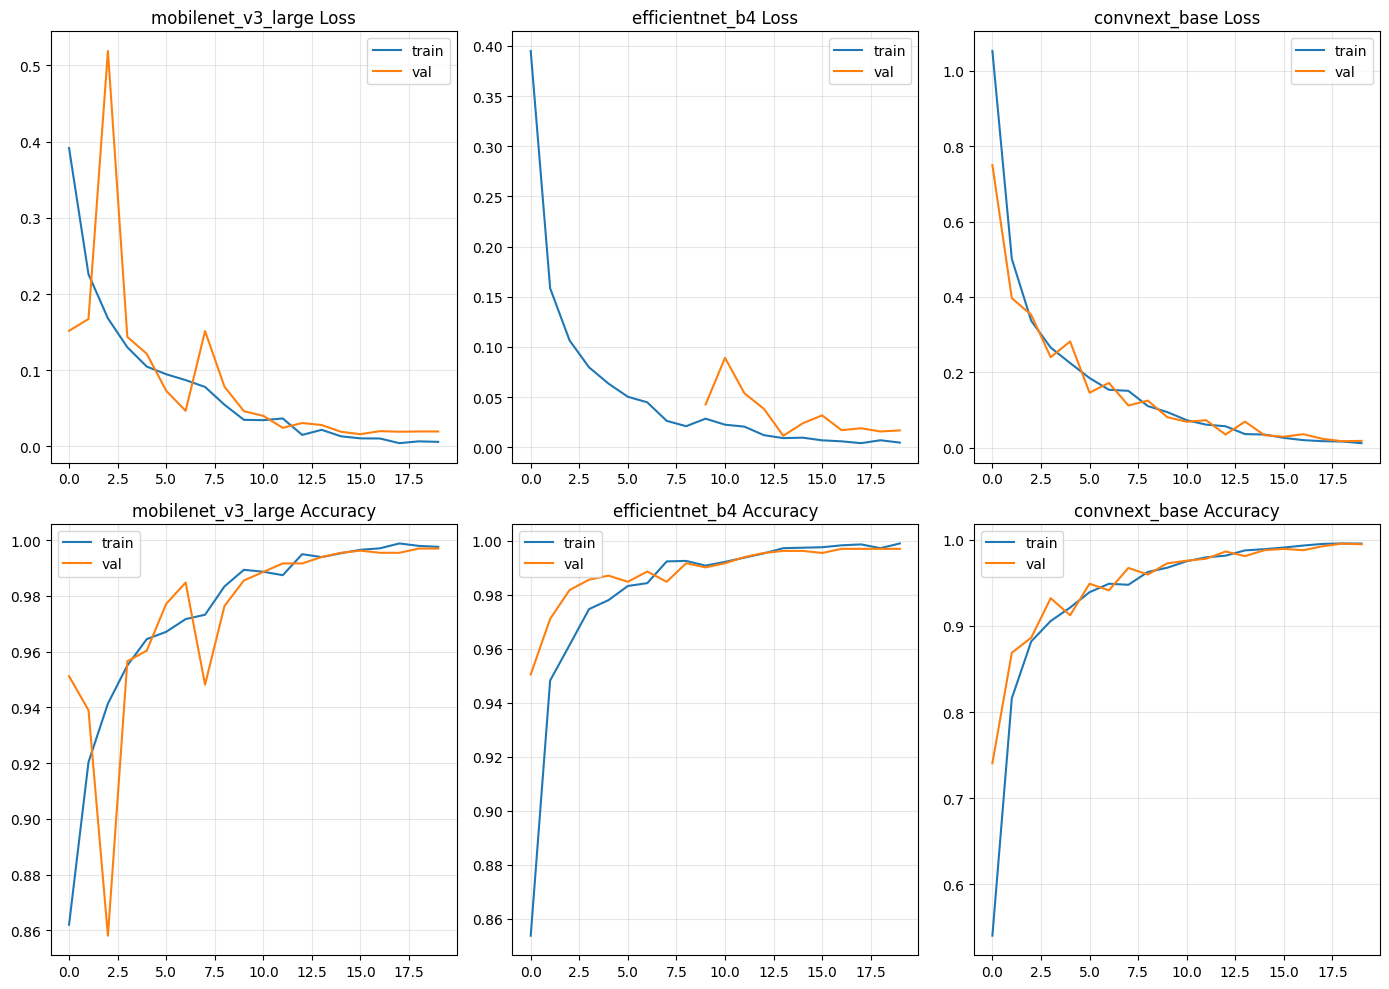

In [7]:
plt.figure(figsize=(14, 10))

n = len(histories)
for i, (name, h) in enumerate(histories.items(), 1):
    plt.subplot(2, n, i)
    plt.plot(h['train_loss'], label='train')
    plt.plot(h['val_loss'],   label='val')
    plt.title(f"{name} Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(2, n, i+n)
    plt.plot(h['train_acc'], label='train')
    plt.plot(h['val_acc'],   label='val')
    plt.title(f"{name} Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

In [8]:
@torch.no_grad()
def ensemble_predict(models_dict, loader):
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(loader, desc="Ensemble Inference"):
        inputs = inputs.to(device)
        batch_probs = []

        for name, model in models_dict.items():
            model.eval()
            with autocast():
                outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            batch_probs.append(probs)

        avg_probs = torch.mean(torch.stack(batch_probs), dim=0)
        _, preds = torch.max(avg_probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)


# Load best models for ensemble
models_dict = {}
for name in model_names:
    model = create_model(name)
    state = torch.load(os.path.join(save_dir, f"best_{name}.pth"), map_location=device)
    model.load_state_dict(state)
    models_dict[name] = model

print("Running ensemble on test set...")
preds, trues = ensemble_predict(models_dict, test_loader)

acc = accuracy_score(trues, preds)
print(f"\nEnsemble Test Accuracy: {acc:.5f}  ({acc*100:.3f}%)")

Running ensemble on test set...


Ensemble Inference:   0%|          | 0/164 [00:00<?, ?it/s]/tmp/ipykernel_26916/235454772.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ensemble Inference: 100%|██████████| 164/164 [00:12<00:00, 13.64it/s]


Ensemble Test Accuracy: 0.99619  (99.619%)


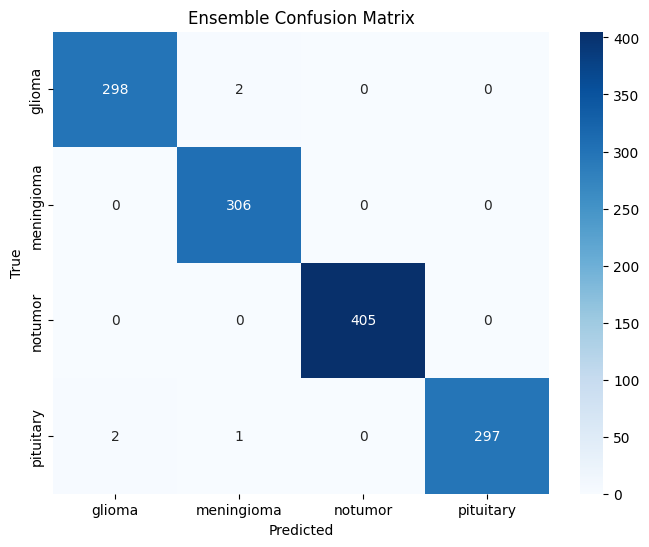

In [9]:
cm = confusion_matrix(trues, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
with open(os.path.join(save_dir, "ensemble_summary.txt"), "w") as f:
    f.write(f"Models: {', '.join(model_names)}\n")
    f.write(f"Ensemble Accuracy: {acc:.5f}\n")
    f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Settings: bs={batch_size}, accum={accum_steps}, epochs={num_epochs}\n")

print(f"Models saved → {save_dir}")
print("Done.")

Models saved → ensemble_brain_tumor_models
Done.
